# Fastdup for Sattelite Imagery
In this notebook we load satellite data from Mafat Competition https://mafatchallenge.mod.gov.il/, which consists of 16 bit grayscale images with rotated bounding boxes.

We show how to work with this dataset using fastdup. It takes 140 seconds to process 18,000 bounding boxes and find all similarities.

We use components gallery to highly suspected wrong bounding boxes as well as correct bounding boxes.


In [17]:
# install latst fastdup (required 0.904 or up)
%pip install fastdup -U --force-reinstall

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached fastdup-0.904-cp38-cp38-macosx_11_0_arm64.whl (32.8 MB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached pandas-1.5.3-cp38-cp38-macosx_11_0_arm64.whl (10.8 MB)
  Using cached sentry_sdk-1.16.0-py2.py3-none-any.whl (184 kB)
  Using cached numpy-1.24.2-cp38-cp38-macosx_11_0_arm64.whl (13.8 MB)
  Using cached opencv_python_headless-4.5.5.64-cp37-abi3-macosx_11_0_arm64.whl (29.9 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached packaging-23.0-py3-none-any.whl (42 kB)
  Using cached Pillow-9.4.0-cp38-cp38-macosx_11_0_arm64.whl (3.0 MB)
  Using cached PyYAML-6.0-cp38-cp38-macosx_12_0_arm64.whl
  Using cached charset_norma

In [1]:
#download mafat traing data, extract the zip file and put the notebook one level below images/ folder

# Prepare annotation for fastdup format

In [18]:
# Here we read the data as given in the competition, one annotation file per each image. We combine all files into a single flat table

In [1]:
import os
files=!ls labelTxt
files = [os.path.join('labelTxt', f) for f in files]

In [2]:
def read_annotations(f):
    with open(f, 'r') as fd:
        lines = fd.readlines()

    bounding_boxes = []

    for line in lines:
        tokens = line.split()
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, tokens[:8])
        label = tokens[8]
        bounding_box = {'annot':f , 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'x3': x3, 'y3': y3, 'x4': x4, 'y4': y4, 'label': label}
        bounding_boxes.append(bounding_box)
    return bounding_boxes

In [3]:
annot = []
for f in files:
    annot.extend(read_annotations(f))

In [4]:
import pandas as pd
df = pd.DataFrame(annot)
df['filename'] = df['annot'].apply(lambda x: x.replace('labelTxt', 'images').replace('.txt', '.tiff'))
df.head()

,annot,x1,y1,x2,y2,x3,y3,x4,y4,label,filename
0,labelTxt/10011_0_0.txt,828.32,18.09,866.47,43.15,775.87,181.07,737.72,156.01,pylon,images/10011_0_0.tiff
1,labelTxt/10011_0_0.txt,817.90,155.27,864.29,185.28,740.46,376.68,694.07,346.67,pylon,images/10011_0_0.tiff
2,labelTxt/10011_0_0.txt,834.47,685.91,875.96,712.86,782.08,857.43,740.59,830.48,pylon,images/10011_0_0.tiff
3,labelTxt/10011_0_0.txt,816.47,431.04,865.36,464.02,743.65,644.47,694.76,611.49,pylon,images/10011_0_0.tiff
4,labelTxt/10011_0_0.txt,719.43,-35.14,770.69,0.74,737.59,48.01,686.33,12.12,pylon,images/10011_0_0.tiff


In [6]:
print('total annotations', len(df))

total annotations 18113


In [7]:
df.index.name = 'index'
df[['filename', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label']].to_csv('mafat.csv',index_label='index')

In [19]:
# This is the reuired input by fastdup
!head mafat.csv

index,filename,x1,y1,x2,y2,x3,y3,x4,y4,label
0,images/10011_0_0.tiff,828.32,18.09,866.47,43.15,775.87,181.07,737.72,156.01,pylon
1,images/10011_0_0.tiff,817.9,155.27,864.29,185.28,740.46,376.68,694.07,346.67,pylon
2,images/10011_0_0.tiff,834.47,685.91,875.96,712.86,782.08,857.43,740.59,830.48,pylon
3,images/10011_0_0.tiff,816.47,431.04,865.36,464.02,743.65,644.47,694.76,611.49,pylon
4,images/10011_0_0.tiff,719.43,-35.14,770.69,0.74,737.59,48.01,686.33,12.12,pylon
5,images/10011_0_0.tiff,834.54,344.16,874.27,369.97,779.75,515.51,740.02,489.7,pylon
6,images/10011_0_0.tiff,1233.3,540.65,1238.65,547.24,1233.78,551.2,1228.43,544.61,heavy_equipment
7,images/10011_0_0.tiff,817.78,769.25,866.68,801.74,746.22,983.05,697.32,950.56,pylon
8,images/10011_1280_0.tiff,701.87,421.42,755.68,465.62,744.99,478.63,691.18,434.43,pylon


# Run fastdup to crop and build a model for the crops

In [1]:
import numpy as np
import cv2

!rm -fr output

In [2]:
import pandas as pd
import fastdup
df = pd.read_csv('mafat.csv')
df['img_filename'] = df['filename']
del df['filename']
fd = fastdup.create(input_dir='.', work_dir='output')


In [3]:
# for running advanced bounding boxes in fastdup please send email to info@databasevisual.com to get your free license. 
# Rotated bounding boxes are not supported in the free version.

In [4]:

fd.run(annotations=df, overwrite=True, license='XXX', bounding_box='rotated', augmentation_additive_margin=15,
       verbose=False, ccthreshold=0.95)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-03-15 06:27:02 [INFO] Going to loop over dir /var/folders/4m/17tfvm293lg5scctpk1cd2940000gn/T/tmpfvaycon7.csv
2023-03-15 06:27:02 [INFO] Found total 18113 images to run on
FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.utes 0 Features
2023-03-15 06:29:06 [INFO] Going to loop over dir /var/folders/4m/17tfvm293lg5scctpk1cd2940000gn/T/crops_input.csv
2023-03-15 06:29:06 [INFO] Found total 18113 images to run on
2023-03-15 06:29:28 [INFO] Found total 18113 images to run onimated: 0 Minutes 0 Features
2023-03-15 06:29:31 [INFO] 3396) Finished write_index() NN model
2023-03-15 06:29:31 [INFO] Stored nn model index file output/nnf.index
2023-03-15 06:29:33 [INFO] Total time took 27053 ms
2023-03-15 06:29:33 [INFO] Found a total of 12 fully identical images (d>0.990), which are 0.02 %
2023-03-15 06:29:33 [INFO] Found a total of 573 nearly identical images(d>0.980), which are 1.05 %
2023-0

# Find suspected wrong bounding boxes

From - crop image name
To - similar images
where the labels are not matching

heavy_equipment


100%|████████████████████████████████████████████| 20/20 [00:00<00:00, 293.53it/s]

Finished OK. Components are stored as image files output/galleries/components_[index].jpg
Stored components visual view in  output/galleries/components.html
Execution time in seconds 2.0



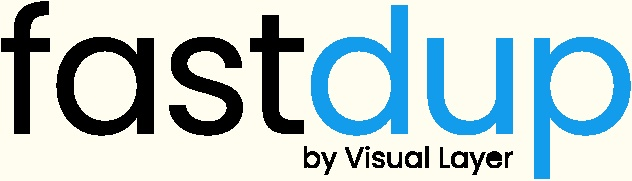
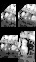
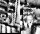
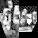
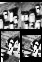
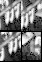
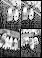
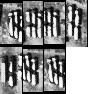
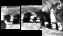
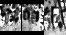
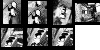
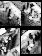
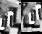
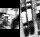

In [13]:
fd.vis.component_gallery(load_crops=True,enhance_image=True,keep_aspect_ratio=True,slice='diff',  num_images=20, save_artifacts=True)

In [9]:
# Looking at the raw cluster to link back cluster name to to file

In [6]:
df = pd.read_csv('output/galleries/components.csv')

In [7]:
df.head()

,Unnamed: 0,component_id,files,label,distance,len
0,2500,2500,"['crops/images13591_6400_1280.tiff_1_412_4_409_9_415_6_418.jpg', 'crops/images13591_6400_1280.tiff_4_410_7_407_12_413_9_416.jpg', 'crops/images13591_6400_1280.tiff_7_408_10_406_15_411_12_414.jpg', 'crops/images1675_3840_11520.tiff_2_77_8_76_10_92_4_93.jpg']","['small_vessel', 'small_vessel', 'small_vessel', 'medium_vessel']",0.9791,4
1,736,736,"['crops/images1081_1280_10240.tiff_556_144_559_139_574_149_571_154.jpg', 'crops/images18849_6400_0.tiff_1080_96_1085_94_1092_112_1087_114.jpg']","['large_vehicle', 'medium_vessel']",0.9777,2
2,4622,4622,"['crops/images1675_3840_11520.tiff_7_36_15_39_6_60_-1_57.jpg', 'crops/images214_10240_1280.tiff_1267_223_1271_221_1276_230_1272_233.jpg']","['medium_vessel', 'small_vessel']",0.9754,2
3,251,251,"['crops/images10669_8960_0.tiff_1178_336_1186_324_1191_326_1183_339.jpg', 'crops/images4079_3840_5120.tiff_169_1175_176_1178_174_1182_167_1179.jpg']","['medium_vessel', 'small_vessel']",0.9753,2
4,8885,8885,"['crops/images5532_1280_0.tiff_815_931_817_935_807_941_804_937.jpg', 'crops/images5532_1280_0.tiff_1073_1007_1073_1002_1085_1003_1085_1008.jpg']","['large_vehicle', 'bus']",0.9742,2


In [15]:
# Looking at good labels

small_aircraft


100%|████████████████████████████████████████████| 20/20 [00:00<00:00, 295.60it/s]

Finished OK. Components are stored as image files output/galleries/components_[index].jpg
Stored components visual view in  output/galleries/components.html
Execution time in seconds 2.0



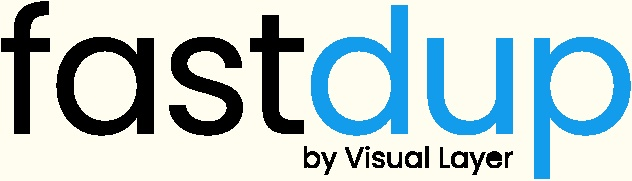
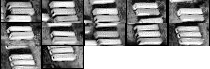
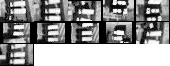
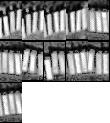
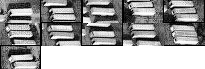
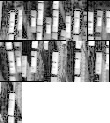
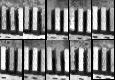
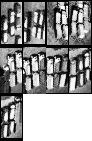
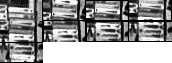
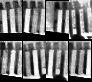
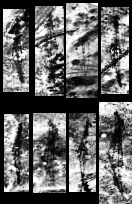
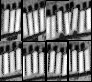
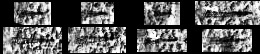
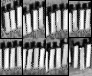
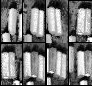
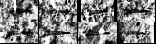
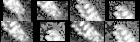
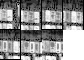
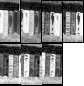
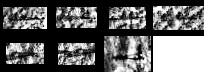
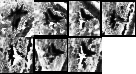

In [16]:
fd.vis.component_gallery(load_crops=True,enhance_image=True,keep_aspect_ratio=True,slice='same',  num_images=20, save_artifacts=True)

In [ ]:
# Let's look on outliers on the satellite image level

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 34836.41it/s]


Stored outliers visual view in  output/galleries/outliers.html



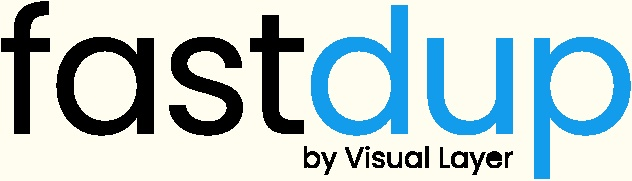
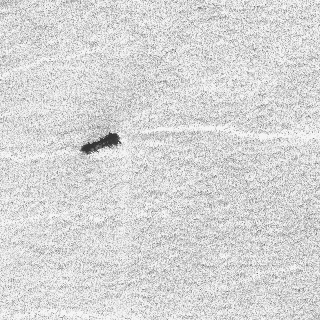
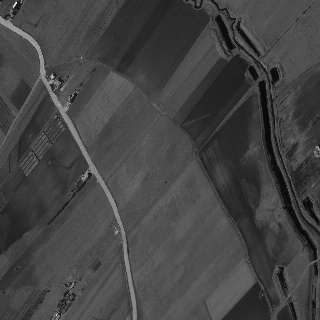
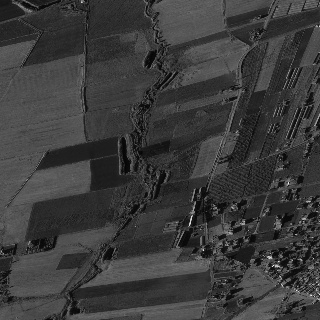
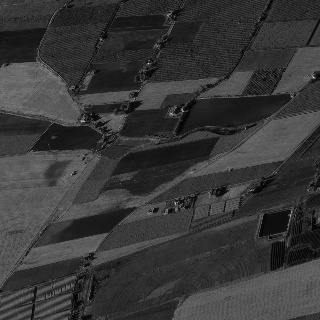
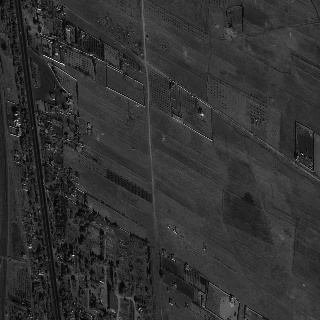
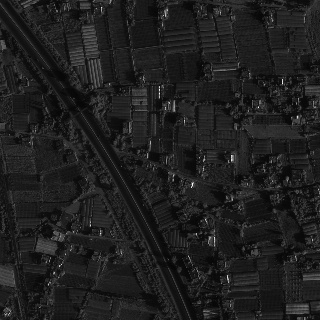
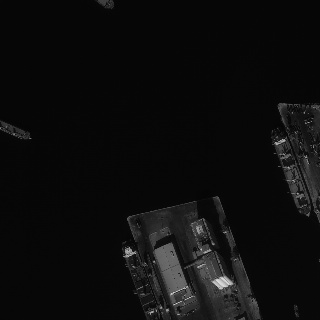
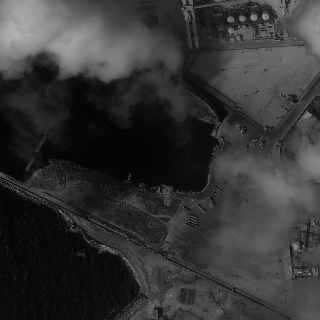
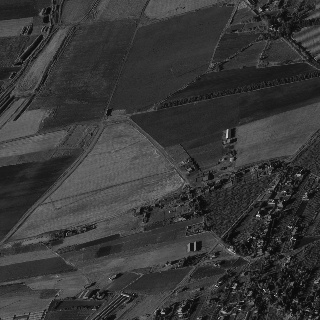
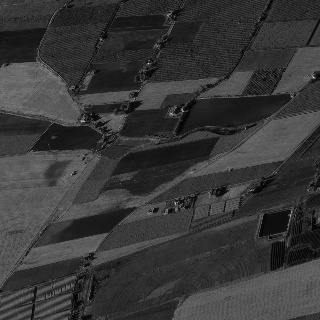
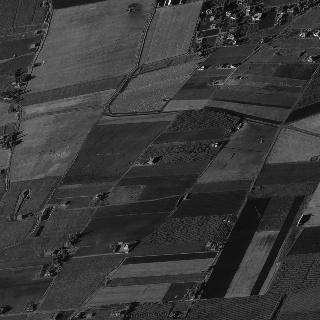
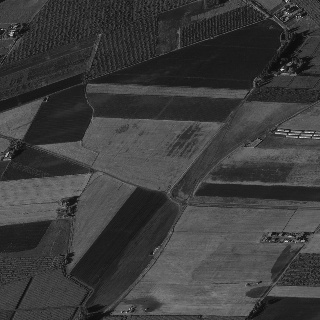
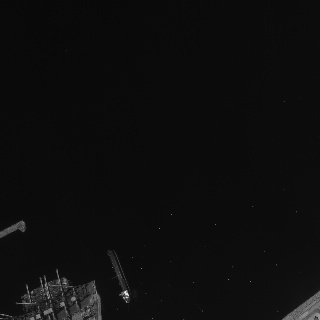
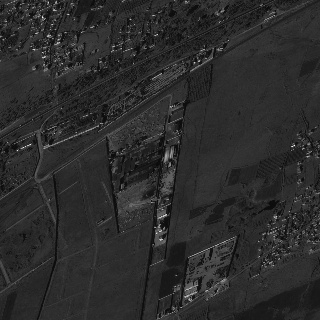
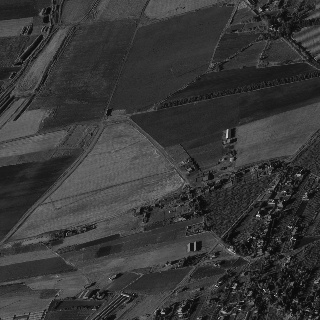
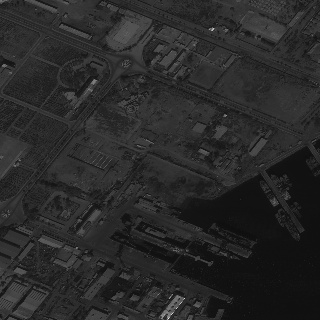
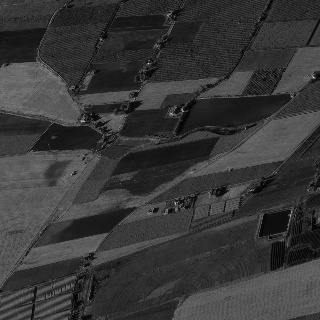
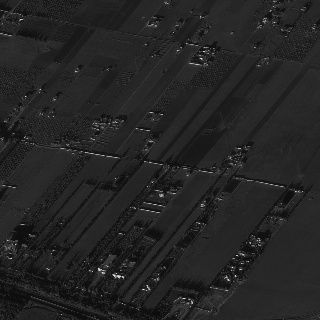
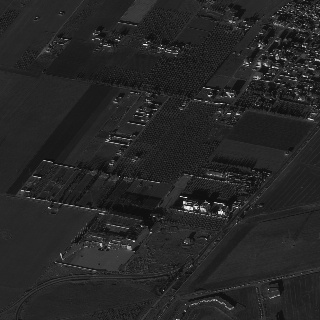
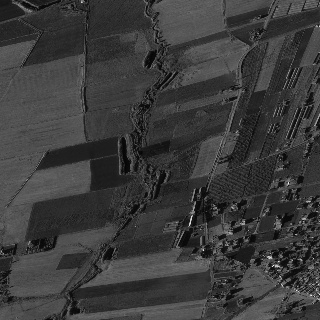

In [20]:
fd.vis.outliers_gallery()

In [22]:
# Now we look at outliers at the crop level

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 34620.75it/s]

Stored outliers visual view in  output/galleries/outliers.html



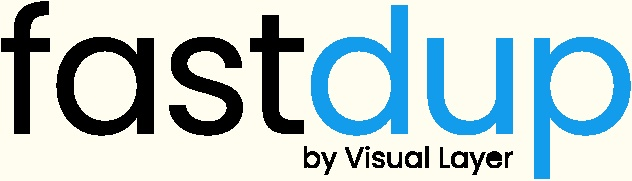
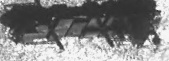
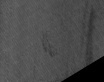
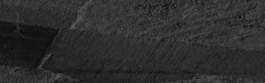
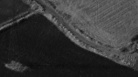
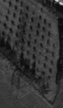
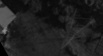
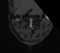
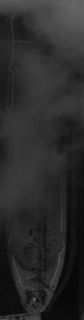
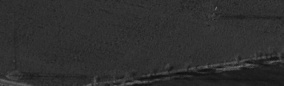
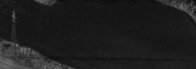
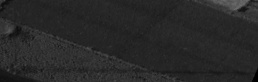
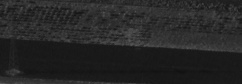
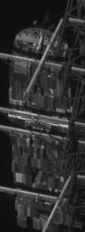
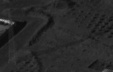
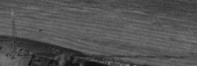
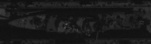
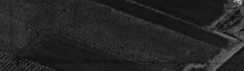
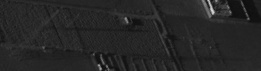
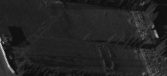
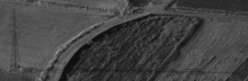

In [21]:
fd.vis.outliers_gallery(load_crops=True)

In [ ]:
# We look for the brightest satellite images

100%|█████████████████████████████████████████████| 20/20 [00:00<00:00, 51.94it/s]


Stored mean visual view in  output/galleries/mean.html



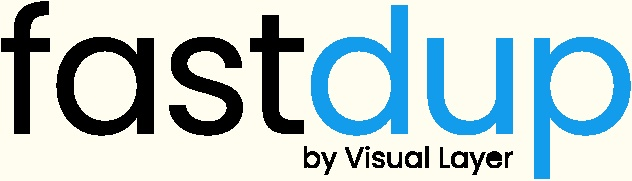
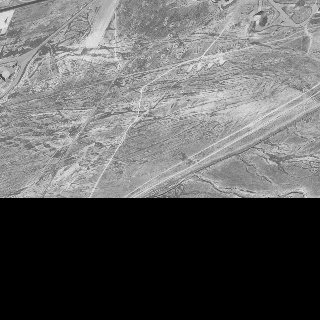
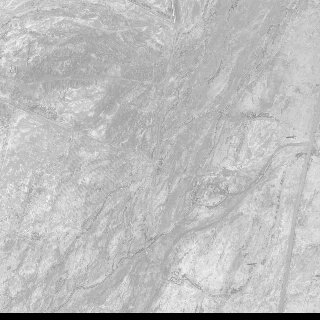
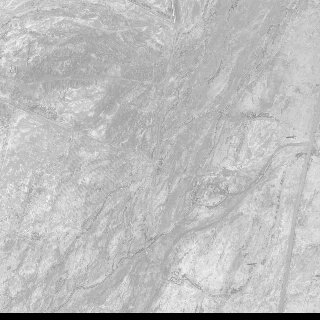
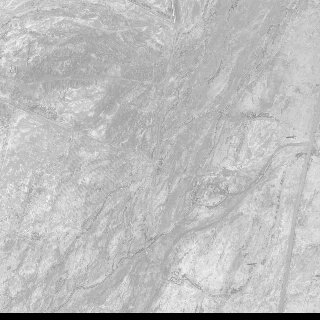
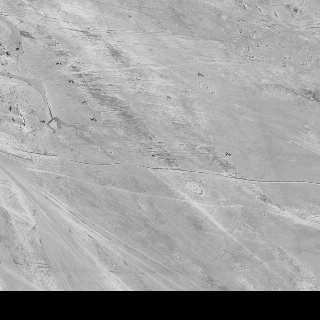
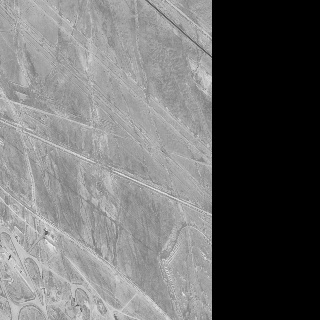
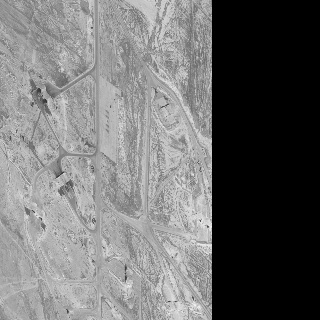
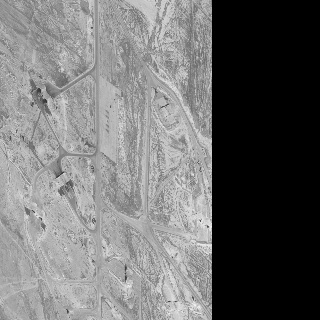
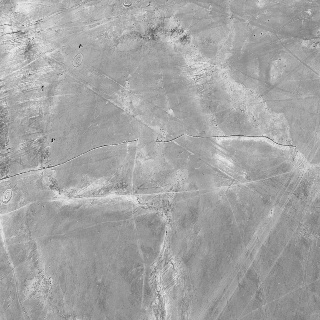
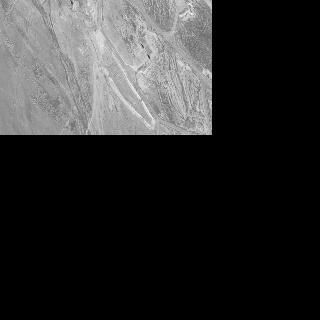
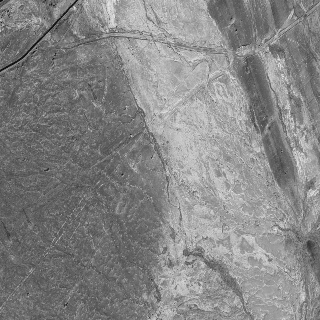
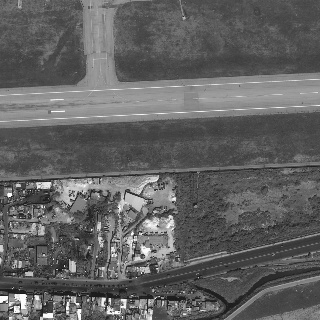
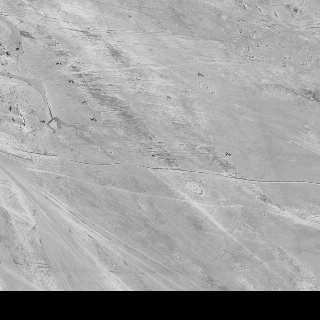
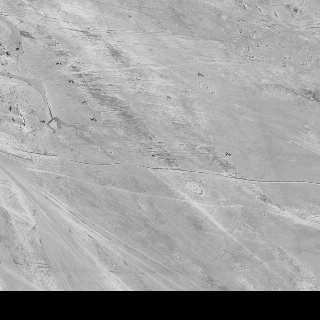
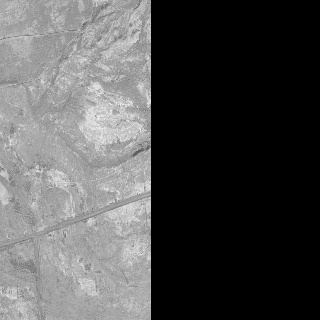
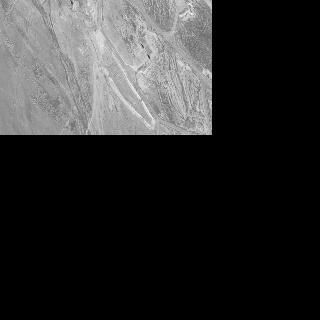
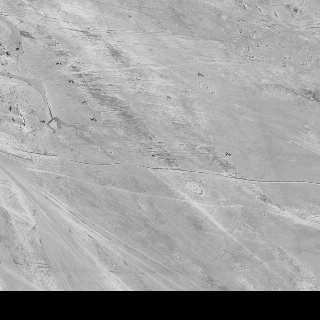
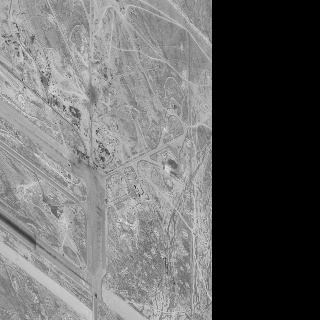
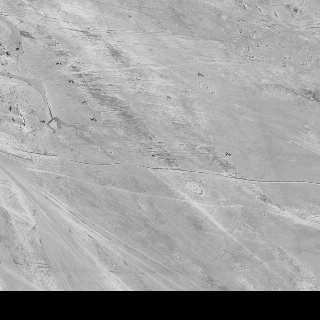
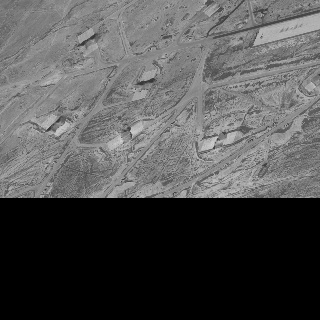

In [23]:
fd.vis.stats_gallery(metric='mean')

In [ ]:
# Now we look for the most blurry images

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 2195.86it/s]

Stored blur visual view in  output/galleries/blur.html



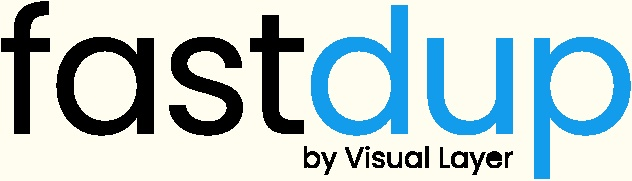

In [27]:
fd.vis.stats_gallery(metric='blur',load_crops=True)